<a href="https://colab.research.google.com/github/cindymustika/RiceLeavesDisease_CNN/blob/main/Rice_Leaves_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Rice Leaves Disease

Dataset yang digunakan terdiri dari **5923** gambar daun padi yang telah dikategorikan ke dalam 4 kelas:
- **Bacterial Blight**
- **Blast**
- **Brown Spot**
- **Tungro**

##Import Library

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

##Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Ekstraksi Dataset

In [ ]:
# Ekstrak file ZIP
import zipfile
zip_path = '/content/drive/MyDrive/Rice_Leaf_Disease/rice_leaves.zip'
extract_path = '/content/rice_leaves'
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Ekstrak file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("File berhasil diekstrak ke:", extract_path)

File berhasil diekstrak ke: /content/rice_leaves


In [ ]:
# Cek struktur folder
!ls -la {extract_path}

total 244
drwxr-xr-x 6 root root  4096 Apr 29 12:45 .
drwxr-xr-x 1 root root  4096 Apr 29 12:44 ..
drwxr-xr-x 2 root root 69632 Apr 29 12:44 Bacterialblight
drwxr-xr-x 2 root root 61440 Apr 29 12:45 Blast
drwxr-xr-x 2 root root 69632 Apr 29 12:45 Brownspot
drwxr-xr-x 2 root root 40960 Apr 29 12:45 Tungro


##Preprocessing Gambar

In [ ]:
# Menyiapkan path untuk data
data_dir = extract_path

# Menyiapkan parameter
img_width, img_height = 224, 224
batch_size = 32
epochs = 10

##Augmentasi Data

In [ ]:
# Data augmentation untuk training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Data preprocessing untuk validation set
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [ ]:
# Load dan preprocess data training
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load dan preprocess data validation
validation_generator = valid_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Mendapatkan nama kelas
class_names = list(train_generator.class_indices.keys())
print("Kelas penyakit daun padi:", class_names)
num_classes = len(class_names)


Found 4747 images belonging to 4 classes.
Found 1185 images belonging to 4 classes.
Kelas penyakit daun padi: ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']


##Arsitektur Model CNN

In [ ]:
def create_simple_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:
# Membuat model
model = create_simple_cnn()

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,908 (91.20 MB)

 Trainable params: 23,907,908 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

##Kompilasi & Pelatihan Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=30,
    callbacks=[model_checkpoint, early_stopping, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.4273 - loss: 1.3209

148/148 ━━━━━━━━━━━━━━━━━━━━ 71s 436ms/step - accuracy: 0.4279 - loss: 1.3195 - val_accuracy: 0.6968 - val_loss: 0.8539 - learning_rate: 1.0000e-04
Epoch 2/30
  1/148 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.6250 - loss: 0.9646

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6250 - loss: 0.9646 - val_accuracy: 0.6900 - val_loss: 0.8502 - learning_rate: 1.0000e-04
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.6483 - loss: 0.8907

148/148 ━━━━━━━━━━━━━━━━━━━━ 61s 411ms/step - accuracy: 0.6484 - loss: 0.8905 - val_accuracy: 0.6959 - val_loss: 0.7566 - learning_rate: 1.0000e-04
Epoch 4/30
  1/148 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.5625 - loss: 1.1247

148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5625 - loss: 1.1247 - val_accuracy: 0.7010 - val_loss: 0.7461 - learning_rate: 1.0000e-04
Epoch 5/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.7073 - loss: 0.7867

148/148 ━━━━━━━━━━━━━━━━━━━━ 81s 549ms/step - accuracy: 0.7074 - loss: 0.7864 - val_accuracy: 0.7542 - val_loss: 0.6664 - learning_rate: 1.0000e-04
Epoch 6/30
  1/148 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7500 - loss: 0.7316

148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7500 - loss: 0.7316 - val_accuracy: 0.7568 - val_loss: 0.6529 - learning_rate: 1.0000e-04
Epoch 7/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.7352 - loss: 0.7059

148/148 ━━━━━━━━━━━━━━━━━━━━ 141s 579ms/step - accuracy: 0.7353 - loss: 0.7058 - val_accuracy: 0.8108 - val_loss: 0.5772 - learning_rate: 1.0000e-04
Epoch 8/30
  1/148 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7188 - loss: 0.6632

148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7188 - loss: 0.6632 - val_accuracy: 0.7998 - val_loss: 0.5743 - learning_rate: 1.0000e-04
Epoch 9/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.7964 - loss: 0.5757

148/148 ━━━━━━━━━━━━━━━━━━━━ 61s 415ms/step - accuracy: 0.7963 - loss: 0.5758 - val_accuracy: 0.8024 - val_loss: 0.5207 - learning_rate: 1.0000e-04
Epoch 10/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7812 - loss: 0.7561 - val_accuracy: 0.8015 - val_loss: 0.5214 - learning_rate: 1.0000e-04
Epoch 11/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7938 - loss: 0.5660

148/148 ━━━━━━━━━━━━━━━━━━━━ 65s 440ms/step - accuracy: 0.7938 - loss: 0.5660 - val_accuracy: 0.8091 - val_loss: 0.5019 - learning_rate: 1.0000e-04
Epoch 12/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7188 - loss: 0.6113 - val_accuracy: 0.7838 - val_loss: 0.5506 - learning_rate: 1.0000e-04
Epoch 13/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.7899 - loss: 0.5588

148/148 ━━━━━━━━━━━━━━━━━━━━ 83s 463ms/step - accuracy: 0.7900 - loss: 0.5586 - val_accuracy: 0.8311 - val_loss: 0.4980 - learning_rate: 1.0000e-04
Epoch 14/30
  1/148 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.7812 - loss: 0.5329

148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7812 - loss: 0.5329 - val_accuracy: 0.8311 - val_loss: 0.4767 - learning_rate: 1.0000e-04
Epoch 15/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.7948 - loss: 0.5411

148/148 ━━━━━━━━━━━━━━━━━━━━ 86s 582ms/step - accuracy: 0.7949 - loss: 0.5409 - val_accuracy: 0.8429 - val_loss: 0.4240 - learning_rate: 1.0000e-04
Epoch 16/30
  1/148 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.8438 - loss: 0.4012

148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8438 - loss: 0.4012 - val_accuracy: 0.8471 - val_loss: 0.4236 - learning_rate: 1.0000e-04
Epoch 17/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8189 - loss: 0.5056

148/148 ━━━━━━━━━━━━━━━━━━━━ 89s 600ms/step - accuracy: 0.8189 - loss: 0.5056 - val_accuracy: 0.8784 - val_loss: 0.3755 - learning_rate: 1.0000e-04
Epoch 18/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8438 - loss: 0.4637 - val_accuracy: 0.8666 - val_loss: 0.3912 - learning_rate: 1.0000e-04
Epoch 19/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8281 - loss: 0.4486

148/148 ━━━━━━━━━━━━━━━━━━━━ 85s 579ms/step - accuracy: 0.8281 - loss: 0.4486 - val_accuracy: 0.8801 - val_loss: 0.3654 - learning_rate: 1.0000e-04
Epoch 20/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.6562 - loss: 0.7289 - val_accuracy: 0.8767 - val_loss: 0.3686 - learning_rate: 1.0000e-04
Epoch 21/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 82s 554ms/step - accuracy: 0.8267 - loss: 0.4567 - val_accuracy: 0.8454 - val_loss: 0.3775 - learning_rate: 1.0000e-04
Epoch 22/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8125 - loss: 0.5814 - val_accuracy: 0.8539 - val_loss: 0.3742 - learning_rate: 1.0000e-04
Epoch 23/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 62s 416ms/step - accuracy: 0.8457 - loss: 0.4188 - val_accuracy: 0.8277 - val_loss: 0.4144 - learning_rate: 1.0000e-04
Epoch 24/30
  1/148 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9062 - loss: 0.3614
Epoch 24: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accura

148/148 ━━━━━━━━━━━━━━━━━━━━ 84s 567ms/step - accuracy: 0.8547 - loss: 0.3860 - val_accuracy: 0.8834 - val_loss: 0.3216 - learning_rate: 2.0000e-05
Epoch 26/30
  1/148 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7500 - loss: 0.5524

148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7500 - loss: 0.5524 - val_accuracy: 0.8834 - val_loss: 0.3198 - learning_rate: 2.0000e-05
Epoch 27/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 81s 548ms/step - accuracy: 0.8568 - loss: 0.3823 - val_accuracy: 0.8767 - val_loss: 0.3299 - learning_rate: 2.0000e-05
Epoch 28/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9062 - loss: 0.3767 - val_accuracy: 0.8750 - val_loss: 0.3322 - learning_rate: 2.0000e-05
Epoch 29/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8664 - loss: 0.3557

148/148 ━━━━━━━━━━━━━━━━━━━━ 124s 443ms/step - accuracy: 0.8664 - loss: 0.3558 - val_accuracy: 0.8953 - val_loss: 0.3055 - learning_rate: 2.0000e-05
Epoch 30/30
  1/148 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.8750 - loss: 0.4336

148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.8750 - loss: 0.4336 - val_accuracy: 0.8953 - val_loss: 0.3037 - learning_rate: 2.0000e-05


In [ ]:
# Simpan model terakhir
model.save('rice_disease_model2.h5')
print("Model tersimpan di 'rice_disease_model_final.h5'")

Model tersimpan di 'rice_disease_model_final.h5'


##Plot Training

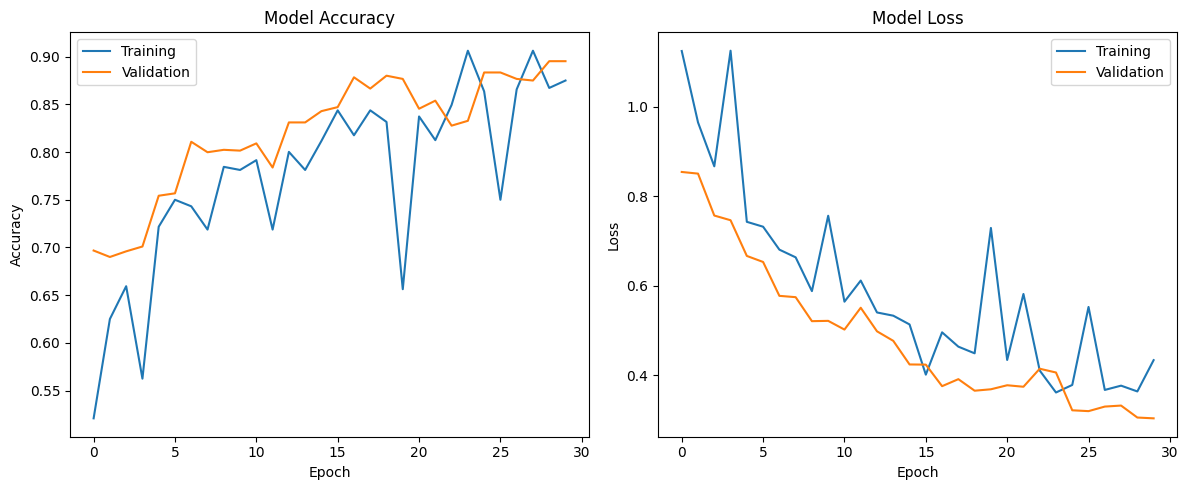

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##Evaluasi Model

In [ ]:
# Evaluasi model
print("Evaluasi model pada data validasi:")
evaluation = model.evaluate(validation_generator)
print(f"Loss: {evaluation[0]:.4f}")
print(f"Accuracy: {evaluation[1]:.4f}")

Evaluasi model pada data validasi:
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9044 - loss: 0.2906
Loss: 0.3034
Accuracy: 0.8954


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step


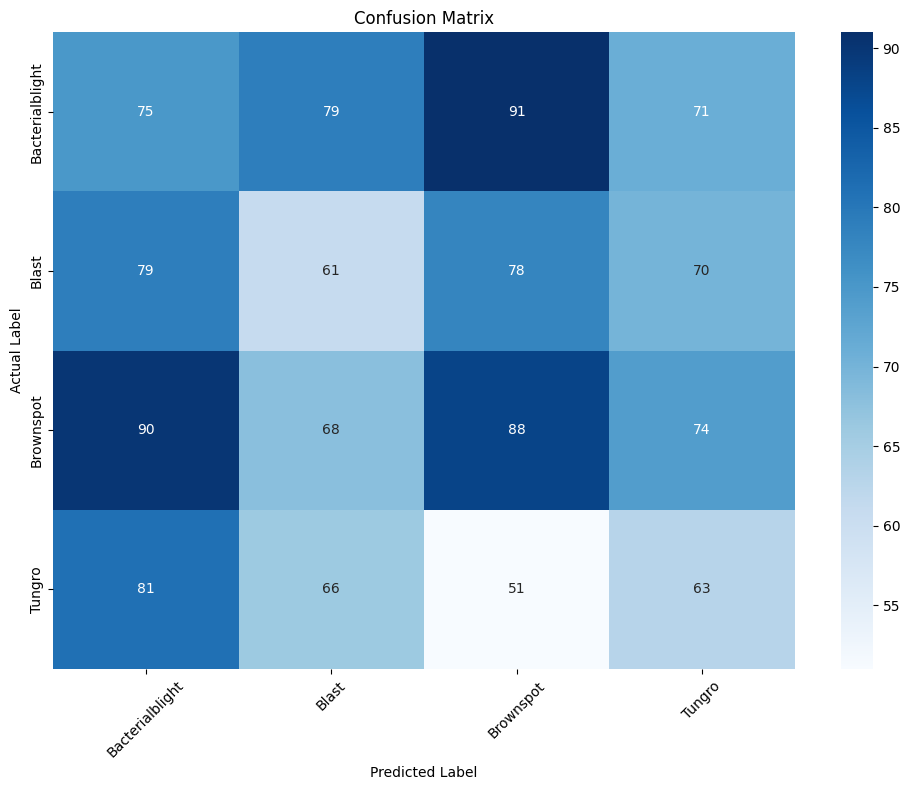


Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.23      0.24      0.23       316
          Blast       0.22      0.21      0.22       288
      Brownspot       0.29      0.28      0.28       320
         Tungro       0.23      0.24      0.23       261

       accuracy                           0.24      1185
      macro avg       0.24      0.24      0.24      1185
   weighted avg       0.24      0.24      0.24      1185



In [ ]:
# Prediksi pada data validasi
validation_steps = validation_generator.samples // batch_size + 1
predictions = model.predict(validation_generator, steps=validation_steps)
predicted_classes = np.argmax(predictions[:validation_generator.samples], axis=1)
true_classes = validation_generator.classes[:validation_generator.samples]

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))


##Visualisasi Hasil

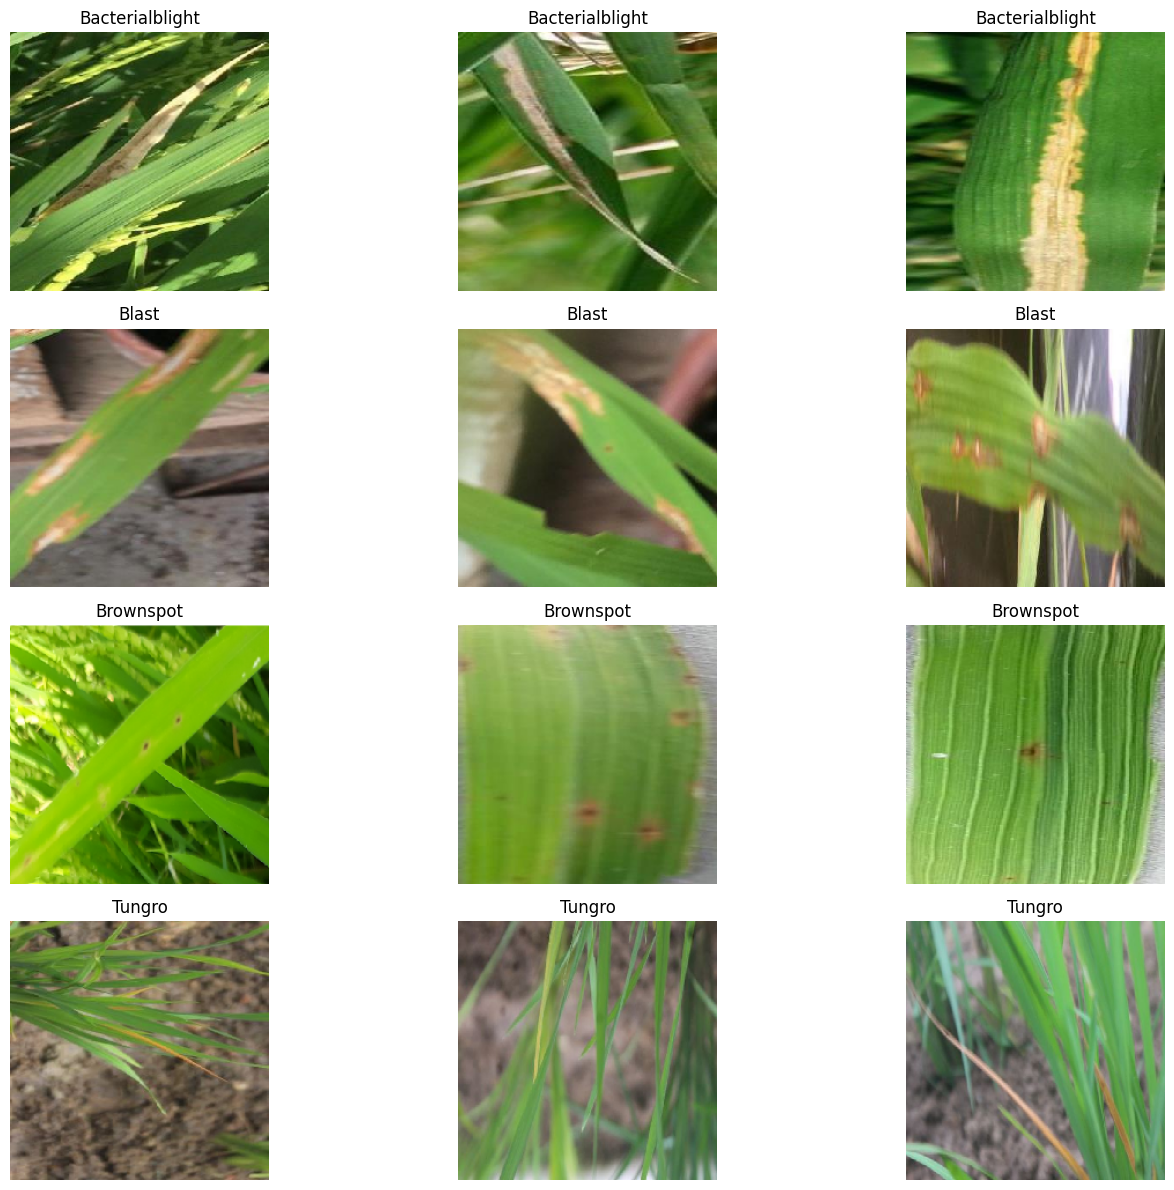

In [ ]:
# Visualisasi beberapa contoh gambar dari setiap kelas
plt.figure(figsize=(15, 12))

for i, class_name in enumerate(class_names):
    # Ambil beberapa gambar dari setiap kelas
    class_path = os.path.join(data_dir, class_name)
    image_files = os.listdir(class_path)[:3]  # Ambil 3 gambar pertama dari setiap kelas

    for j, image_file in enumerate(image_files):
        image_path = os.path.join(class_path, image_file)
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

        plt.subplot(len(class_names), 3, i*3 + j + 1)
        plt.imshow(img_array)
        plt.title(f"{class_name}")
        plt.axis('off')

plt.tight_layout()
plt.show()


##Prediksi

In [ ]:
# Fungsi untuk memprediksi gambar baru
def predict_disease(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction) * 100

    print(f"Prediksi: {class_names[predicted_class]}")
    print(f"Tingkat kepercayaan: {confidence:.2f}%")

    # Tampilkan gambar
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Prediksi: {class_names[predicted_class]} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    return class_names[predicted_class], confidence


In [ ]:
# Rekomendasi penanganan untuk setiap penyakit
def get_disease_recommendation(disease_name):
    recommendations = {
        'Bacterialblight': """

        # Rekomendasi Penanganan Bacterial Blight (Hawar Daun Bakteri)

        a. Gejala:
        - Bercak berair pada daun yang kemudian berubah menjadi kuning keabu-abuan
        - Bercak meluas membentuk hawar (blight) sepanjang tepi daun
        - Daun menguning dan mengering

        b. Penanganan:
        1. Pengendalian Kultur Teknis:
           - Gunakan varietas tahan penyakit seperti Inpari 32, Inpari 33, atau Ciherang
           - Jaga jarak tanam yang tepat (25x25 cm) untuk mengurangi kelembaban
           - Berikan pupuk N sesuai rekomendasi, hindari pemupukan N berlebihan
           - Lakukan pergiliran tanaman untuk memutus siklus hidup patogen

        2. Pengendalian Fisik dan Mekanis:
           - Cabut dan musnahkan tanaman yang terinfeksi parah
           - Bersihkan gulma di sekitar area persawahan
           - Keringkan sawah secara periodik (5-7 hari)

        3. Pengendalian Kimiawi:
           - Semprotkan bakterisida berbahan aktif streptomisin sulfat atau oksitetrasiklin
           - Aplikasikan fungisida berbahan tembaga seperti copper oxychloride
           - Lakukan penyemprotan pada pagi hari dengan interval 7-10 hari sekali

        4. Pengendalian Hayati:
           - Aplikasikan Pseudomonas fluorescens sebagai agen biokontrol
           - Gunakan Bacillus subtilis untuk menekan pertumbuhan bakteri patogen
        """,

        'Blast': """
        # Rekomendasi Penanganan Blast (Blas)

        a. Gejala:
        - Bercak berbentuk belah ketupat dengan pusat berwarna abu-abu/putih
        - Bercak dengan tepi berwarna coklat atau coklat kemerahan
        - Pada kondisi parah, daun bisa mengering sepenuhnya

        b. Penanganan:
        1. Pengendalian Kultur Teknis:
           - Tanam varietas tahan blast seperti Inpari 7, Inpari 9, atau Sintanur
           - Atur waktu tanam untuk menghindari kondisi cuaca yang mendukung penyakit
           - Hindari pemupukan nitrogen berlebihan dan seimbangkan dengan pupuk K
           - Jaga pengairan yang konsisten, hindari sawah kering dan basah berselang

        2. Pengendalian Fisik dan Mekanis:
           - Buang sisa-sisa tanaman setelah panen dan bakar untuk mencegah sumber inokulum
           - Sanitasi lahan secara rutin untuk mengurangi sumber penyakit
           - Kelola drainase dengan baik untuk mengurangi kelembaban tinggi

        3. Pengendalian Kimiawi:
           - Aplikasikan fungisida sistemik berbahan aktif azoxystrobin, difenoconazole, atau tricyclazole
           - Semprotkan fungisida kontak seperti mancozeb atau propineb
           - Lakukan rotasi fungisida untuk mencegah resistensi
           - Aplikasikan pada fase kritis (pembibitan, anakan maksimum, dan pembungaan)

        4. Pengendalian Hayati:
           - Gunakan Trichoderma spp. sebagai agen antagonis terhadap patogen blast
           - Aplikasikan mikroba menguntungkan seperti Bacillus spp. atau Pseudomonas spp.
        """,

        'Brownspot': """
        # Rekomendasi Penanganan Brown Spot (Bercak Coklat)

        a. Gejala:
        - Bercak oval berwarna coklat pada daun
        - Bercak memiliki pusat abu-abu atau keputihan
        - Bintik-bintik coklat pada bulir padi

        b. Penanganan:
        1. Pengendalian Kultur Teknis:
           - Gunakan varietas tahan seperti Ciherang, IR64, atau Mekongga
           - Pastikan keseimbangan nutrisi tanah, terutama kalium dan silika
           - Hindari kondisi kekeringan dengan manajemen air yang baik
           - Lakukan pergiliran tanaman dengan tanaman bukan padi

        2. Pengendalian Fisik dan Mekanis:
           - Buang dan bakar sisa tanaman yang terinfeksi
           - Bersihkan gulma di sekitar area persawahan
           - Lakukan pengolahan tanah secara menyeluruh sebelum tanam

        3. Pengendalian Kimiawi:
           - Aplikasikan fungisida berbahan aktif propiconazole, tebuconazole, atau mancozeb
           - Berikan fungisida secara preventif pada fase pertumbuhan kritis
           - Lakukan penyemprotan dengan interval 10-14 hari pada musim hujan
           - Perlakukan benih dengan fungisida sistemik sebelum tanam

        4. Pengendalian Hayati:
           - Aplikasikan Trichoderma harzianum sebagai antagonis patogen
           - Gunakan Pseudomonas fluorescens untuk meningkatkan ketahanan tanaman

        5. Perbaikan Nutrisi Tanah:
           - Tambahkan pupuk silika untuk meningkatkan ketahanan tanaman
           - Perbaiki pH tanah jika terlalu asam (pH optimal 5,5-6,5)
           - Tambahkan bahan organik untuk meningkatkan kesuburan tanah
        """,

        'Tungro': """
        # Rekomendasi Penanganan Tungro

        a. Gejala:
        - Daun berwarna kuning hingga oranye
        - Pertumbuhan tanaman terhambat dan kerdil
        - Jumlah anakan berkurang
        - Malai kecil dengan bulir tidak terisi penuh

        b. Penanganan:
        1. Pengendalian Vektor (Wereng Hijau):
           - Gunakan insektisida berbahan aktif buprofezin, imidacloprid, atau fipronil
           - Lakukan aplikasi insektisida pada pagi atau sore hari
           - Monitoring populasi wereng hijau secara rutin
           - Gunakan perangkap kuning untuk memantau populasi wereng

        2. Pengendalian Kultur Teknis:
           - Tanam varietas tahan Tungro seperti Tukad Unda, Tukad Petanu, atau Tukad Balian
           - Terapkan sistem tanam serempak dalam satu hamparan luas
           - Atur waktu tanam untuk menghindari puncak populasi wereng hijau
           - Buat periode bebas tanam padi selama 2-3 bulan untuk memutus siklus virus

        3. Pengendalian Fisik dan Mekanis:
           - Cabut dan musnahkan tanaman yang terinfeksi Tungro
           - Bersihkan gulma yang dapat menjadi inang alternatif virus dan vektor
           - Gunakan tanaman perangkap di sekitar lahan

        4. Pengendalian Hayati:
           - Konservasi musuh alami wereng hijau, seperti laba-laba, kumbang, dan parasitoid
           - Aplikasikan jamur entomopatogen seperti Beauveria bassiana atau Metarhizium anisopliae

        5. Pendekatan Terintegrasi:
           - Kombinasikan berbagai metode pengendalian untuk efektivitas maksimal
           - Lakukan rotasi penggunaan insektisida untuk mencegah resistensi
           - Lakukan pemantauan kesehatan tanaman secara rutin
        """
    }

    return recommendations.get(disease_name, "Rekomendasi tidak tersedia untuk penyakit ini.")


##Contoh Prediksi Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Prediksi: Bacterialblight
Tingkat kepercayaan: 99.10%


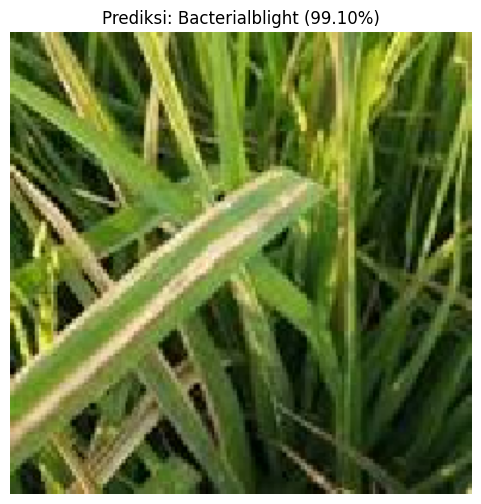



        # Rekomendasi Penanganan Bacterial Blight (Hawar Daun Bakteri)

        a. Gejala:
        - Bercak berair pada daun yang kemudian berubah menjadi kuning keabu-abuan
        - Bercak meluas membentuk hawar (blight) sepanjang tepi daun
        - Daun menguning dan mengering

        b. Penanganan:
        1. Pengendalian Kultur Teknis:
           - Gunakan varietas tahan penyakit seperti Inpari 32, Inpari 33, atau Ciherang
           - Jaga jarak tanam yang tepat (25x25 cm) untuk mengurangi kelembaban
           - Berikan pupuk N sesuai rekomendasi, hindari pemupukan N berlebihan
           - Lakukan pergiliran tanaman untuk memutus siklus hidup patogen

        2. Pengendalian Fisik dan Mekanis:
           - Cabut dan musnahkan tanaman yang terinfeksi parah
           - Bersihkan gulma di sekitar area persawahan
           - Keringkan sawah secara periodik (5-7 hari)

        3. Pengendalian Kimiawi:
           - Semprotkan bakterisida berbahan aktif streptomisin sulfat atau 

In [ ]:
# Contoh prediksi gambar
test_image_path = '/content/drive/MyDrive/Rice_Leaf_Disease/test_image1.jpeg'
predicted_disease, confidence = predict_disease(test_image_path)

# Tampilkan rekomendasi untuk penyakit yang diprediksi
print(get_disease_recommendation(predicted_disease))